# Lars using langgraph

In [92]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from typing import Annotated,Optional,Literal,TypedDict,List,Dict

In [99]:
from langchain.chat_models import init_chat_model
from langchain_core.prompts import PromptTemplate
from langchain.tools import tool
from langchain.agents import create_agent

In [100]:
import operator
import random

## Lars Context

In [89]:
ROBOTS = [
    {
        'name' : ['arm_1'],
        'type' : 'ARM',
        'description' : 'ARM is capable of picking and placing objects but is static at Delivery Zone and cannot navigate to other locations'
    },
    {
        'name' : ['agv_1','agv_2'],
        'type' : 'AGV',
        'description' : 'AGV is capable of navigating to Delivery Zone, Drop Zone 1, Drop Zone 2, but is not capable of picking or placing objects'
    }
    ]

OBJECTS = ['ball', 'pen', 'glass', 'mouse']
LOCATIONS = ['Delivery Zone','Drop Zone 1', 'Drop Zone 2']

LOCATION_INFO = [
    {
        'name' : 'Delivery Zone',
        'description' : 'All objects from object list are located here for pickup and only the arm_1 is located here'
    },
    {
        'name' : 'Drop Zone 1',
        'description' : 'Location for agv_1 or agv_2 to drop the objects, separate from other locations.'
    },
    {
        'name' : 'Drop Zone 2',
        'description' : 'Location for agv_1 or agv_2 to drop the objects, separate from other locations.'
    },
    ]


# LLMs

In [101]:
planner_model = init_chat_model(
    model="gemma3:4b",
    model_provider="ollama",
    temperature = 0
    )

master_model = init_chat_model(
    model="gemma3:4b",
    model_provider="ollama",
    temperature = 0
    )

agent_model = init_chat_model(
    model="functiongemma:latest",
    model_provider="ollama",
    temperature = 0
    )


planner_model.invoke('hi')

AIMessage(content="Hi there! How's your day going so far? Is there anything you'd like to chat about, or were you just saying hello? 😊 \n\nI'm here to help with just about anything – answering questions, brainstorming ideas, writing stories, or just having a conversation.", additional_kwargs={}, response_metadata={'model': 'gemma3:4b', 'created_at': '2026-02-22T11:46:16.2767722Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5600209200, 'load_duration': 2778429000, 'prompt_eval_count': 10, 'prompt_eval_duration': 147795200, 'eval_count': 60, 'eval_duration': 2573846700, 'logprobs': None, 'model_name': 'gemma3:4b', 'model_provider': 'ollama'}, id='lc_run--019c852b-de73-7a01-bf73-a2cb95b6e1aa-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 10, 'output_tokens': 60, 'total_tokens': 70})

# Planner 

### Planner Output Schema

In [79]:
class PlannerStepSchema(BaseModel):
    step_no : int = Field(description='Denotes the current step number')
    robot_type : Literal["ARM","AGV"] = Field(description='Robot needed for executing the action')
    action : str = Field(description='The action to perform')
    dependencies : Optional[List[int]] = Field(description='Any dependency with previous step')
    

class PlannerSchema(BaseModel):
    plan : List[PlannerStepSchema]

## Lars State Schema

In [194]:
class LarsSchema(TypedDict):
    task : str
    plan : PlannerSchema
    completed_steps: Annotated[List[int],operator.add]
    results : Annotated[List[str],operator.add]
    active_step : PlannerStepSchema
    robots_status : Dict[str,Literal["Busy","Free"]]
    total_steps_in_plan : int
    

### Planner System Prompt

In [182]:
def get_planner_prompt():
    prompt = """
    System Role: You are a Robotic Mission Planner. Your task is to decompose a complex mission into a sequence of actionable primitives for a heterogeneous fleet of robots.
    
    The Mission: {task}

    The Robot Fleet: {robots}

    Environment Context: {locations_info}
    
    When Generating Plan :
        - Make sure that you plan does not conflict with any information you have.
        - Always keep in mind robots locations and capabilities.
        - Multi-Parent Logic: If an action involves two entities (e.g., an Arm placing an item on an AGV), the step MUST depend on BOTH the Arm's previous step AND the AGV's previous step.
        - Gripper State: A 'place' action MUST depend on the 'pick' action for that specific object.
        - Location State: An action at a location MUST depend on the 'navigate' action to that location.
        - Understand the dependency concept from the below example.
    
    Example:
        task = 'move ball and pen to drop zone 1'
        plan = [
            [
                step_no = 1,
                robot_type = 'AGV',
                action = 'agv_1 navigates to Delivery Zone',
                dependencies = []
            ],
            [
                step_no = 2,
                robot_type = 'ARM',
                action = 'arm_1 picks ball',
                dependencies = []
            ],
            [
                step_no = 3,
                robot_type = 'ARM',
                action = 'arm_1 place ball on agv_1',
                dependencies = [1,2]
            ],
            [
                step_no = 4,
                robot_type = 'AGV',
                action = 'agv_1 navigates to Drop Zone 1',
                dependencies = [3]
            ],
            [
                step_no = 5,
                robot_type = 'AGV',
                action = 'agv_2 navigates to Delivery Zone',
                dependencies = []
            ],
            [
                step_no = 6,
                robot_type = 'ARM',
                action = 'arm_1 picks pen',
                dependencies = [3]
            ],
            [
                step_no = 7,
                robot_type = 'ARM',
                action = 'arm_1 place pen on agv_2',
                dependencies = [5,6]
            ],
            [
                step_no = 8,
                robot_type = 'AGV',
                action = 'agv_2 navigates to Drop Zone 1',
                dependencies = [7]
            ],
        ]
    """
    return prompt

### Planner Node

In [195]:
def plannerLLM(state:LarsSchema):
    task = state['task']
    model = planner_model.with_structured_output(PlannerSchema)
    
    template = PromptTemplate(
        template=get_planner_prompt(),
        input_variables=['task','robots','objects','locations','locations_info']
    )
    
    chain = template | model
    
    response = chain.invoke(
        {
            'task' : task,
            'robots' : ROBOTS,
            'locations_info' : LOCATION_INFO,
        }
    )
    print('________________________ From Planner : ')
    print('Plan Generated :')
    print()
    for step in response.plan:
        print(step)
    
    return {'plan':response.plan[::-1],'total_steps_in_plan':len(response.plan)}
    

# Master

### Master System Prompt

In [196]:
def get_master_prompt():
    prompt = """
    
    
    
    """
    
    return prompt

### Master Node

In [216]:
def Master(state:LarsSchema):
    
    plan = state['plan']
    if len(state['completed_steps']) == state['total_steps_in_plan']:
        step = None
        return {'active_step':step}

    step = plan[-1]
    action = step.action
    robot_needed = step.robot_type
    dependencies = step.dependencies
    step_no = step.step_no
    
    print()
    print('________________________ From Master : ')
    print('Step No : ',step_no)
    print('Action To Execute : ',action)
    print('Robot Needed : ',robot_needed)
    print('Dependencies Of This Action : ',dependencies)
    print()
    
    if dependencies:
        for dep in dependencies:
            if dep in state['completed_steps']:
                return {'active_step':step}
            else:
                print('Waiting for dependency to complete')
                return {'active_step':step}
    else:
        return {'active_step':step}

# Arm Agent

### Tool

In [217]:
@tool
def pick_object(x:float, y:float, z:float) -> Literal['Object Picked','Picking Error']:
    """
    Arm can perform any object picking operation using this tool
    """
    return random.choice(['Object Picked','Picking Error'])



@tool
def place_object(x:float, y:float, z:float) -> Literal['Object Placed','Placing Error']:
    """
    Arm can perform any object placing operation using this tool
    """
    return random.choice(['Object Placed','Placing Error'])

arm_system_prompt = """
you are a robotic arm agent who have tools like ['pick object','place object'] for picking and placing the object respectively, 
according to user query take the necessarry action.
"""
    

### Arm Node

In [218]:

def armAgent(state:LarsSchema):
    
    action_to_perform = state["active_step"].action
    messages = [{'role':'system','content':arm_system_prompt},
                {"role": "user", "content": action_to_perform}]
    
    agent = create_agent(
        model=agent_model,
        tools=[pick_object,place_object]
    )
    
    response = agent.invoke({'messages':[{"role": "user", "content": action_to_perform}]})
    
    if response['messages'][-2].content == "Object Placed":
        print('________________________ From Arm : ',response['messages'][-2].content)
        state['plan'] = state['plan'].pop()
        return {'results':[response['messages'][-1].content],'completed_steps':[state['active_step'].step_no]}
    
    else:
        print('________________________ From Arm : ',response['messages'][-2].content)
        state['plan'] = state['plan'].pop()
        return {'results':[response['messages'][-1].content], 'completed_steps':[state['active_step'].step_no]}
        

# Agv Agent

### Tool

In [219]:
@tool
def navigate(x:float, y:float) -> Literal['Navigation Success','Navigation Failed']:
    """
    Agv can naviagte using this tool
    """
    return random.choice(['Navigation Success','Navigation Failed'])

agv_system_prompt = """
you are autonomous vehicle agent who have tools like [navigate] for moving around the environment, 
according to user query take the necessarry action.
"""

### Agv Node

In [220]:
def agvAgent(state:LarsSchema):
    
    action_to_perform = state["active_step"].action
    messages = [{'role':'system','content':agv_system_prompt},
                {"role": "user", "content": action_to_perform}]
    
    agent = create_agent(
        model=agent_model,
        tools=[navigate],
    )
    response = agent.invoke({'messages':messages})
    
    if response['messages'][-2].content == "Navigation Success":
        print('________________________ From Agv : ',response['messages'][-2].content)
        state['plan'] = state['plan'].pop()
        return {'results':[response['messages'][-1].content],'completed_steps':[state['active_step'].step_no]}
    else:
        print('________________________ From Agv : ',response['messages'][-2].content)
        state['plan'] = state['plan'].pop()
        return {'results':[response['messages'][-1].content], 'completed_steps':[state['active_step'].step_no]}
   

## Action Router

In [221]:
def route_master_instruction(state:LarsSchema):
    
    if state['active_step'] == None:
        return 'Plan fully executed'
    
    elif state['active_step'].robot_type == 'ARM':
        print('Calling Arm')
        return 'use_arm'
    
    elif state['active_step'].robot_type == 'AGV':
        print('Calling Agv')
        return 'use_agv'
    
    else:
        return "No command from master"
    

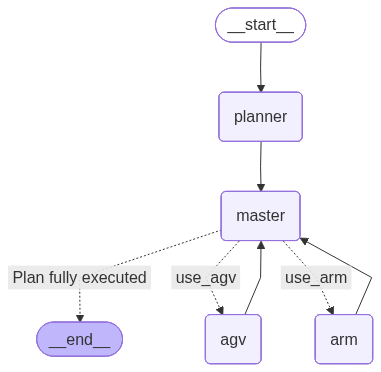

In [222]:
lars = StateGraph(LarsSchema)

lars.add_node('planner',plannerLLM)
lars.add_node('master', Master)
lars.add_node('arm',armAgent)
lars.add_node('agv',agvAgent)

lars.add_edge(START,'planner')
lars.add_edge('planner','master')

lars.add_conditional_edges('master',route_master_instruction,{'use_arm':'arm','use_agv':'agv','Plan fully executed':END})
lars.add_edge('agv','master')
lars.add_edge('arm','master')

lars_wk = lars.compile()
lars_wk



In [223]:
initial_state = {'task':'move ball, pen to drop zone 1'}

final_state = lars_wk.invoke(initial_state)

final_state

________________________ From Planner : 
Plan Generated :

step_no=1 robot_type='AGV' action='agv_1 navigates to Delivery Zone' dependencies=[]
step_no=2 robot_type='ARM' action='arm_1 picks ball' dependencies=[]
step_no=3 robot_type='ARM' action='arm_1 place ball on agv_1' dependencies=[1, 2]
step_no=4 robot_type='AGV' action='agv_1 navigates to Drop Zone 1' dependencies=[3]

________________________ From Master : 
Step No :  1
Action To Execute :  agv_1 navigates to Delivery Zone
Robot Needed :  AGV
Dependencies Of This Action :  []

Calling Agv
________________________ From Agv :  Navigation Success

________________________ From Master : 
Step No :  2
Action To Execute :  arm_1 picks ball
Robot Needed :  ARM
Dependencies Of This Action :  []

Calling Arm
________________________ From Arm :  Picking Error

________________________ From Master : 
Step No :  3
Action To Execute :  arm_1 place ball on agv_1
Robot Needed :  ARM
Dependencies Of This Action :  [1, 2]

Calling Arm
________

{'task': 'move ball, pen to drop zone 1',
 'plan': [],
 'completed_steps': [1, 2, 3, 4],
 'results': ['The autonomous vehicle has navigated to the Delivery Zone.',
  'The arm picking operation failed due to an error. The picking operation could not be performed.',
  'The ball has been placed on the agv_1 coordinates 1, 5, and 2.',
  'The navigation attempt to navigate to Drop Zone 1 failed.'],
 'active_step': None,
 'total_steps_in_plan': 4}